In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scanpy as scp
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import matplotlib.patches as mpatches
import igraph
import scipy.stats as st
import bbknn
import os

from parameters import *

import sys
sys.path.append('../')
import single_cell_tools.tools as scttools
import single_cell_tools.plot as sctplot

2022-08-22 13:26:13.283134: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-22 13:26:13.283153: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
l = ("GSE145886_sample1-4_P",
    "GSE145886_sample5-8_P",
    "GSE145886_sample9_P",
    "GSE145886_sample10_P",
    "GSE145886_sample11-12_P")

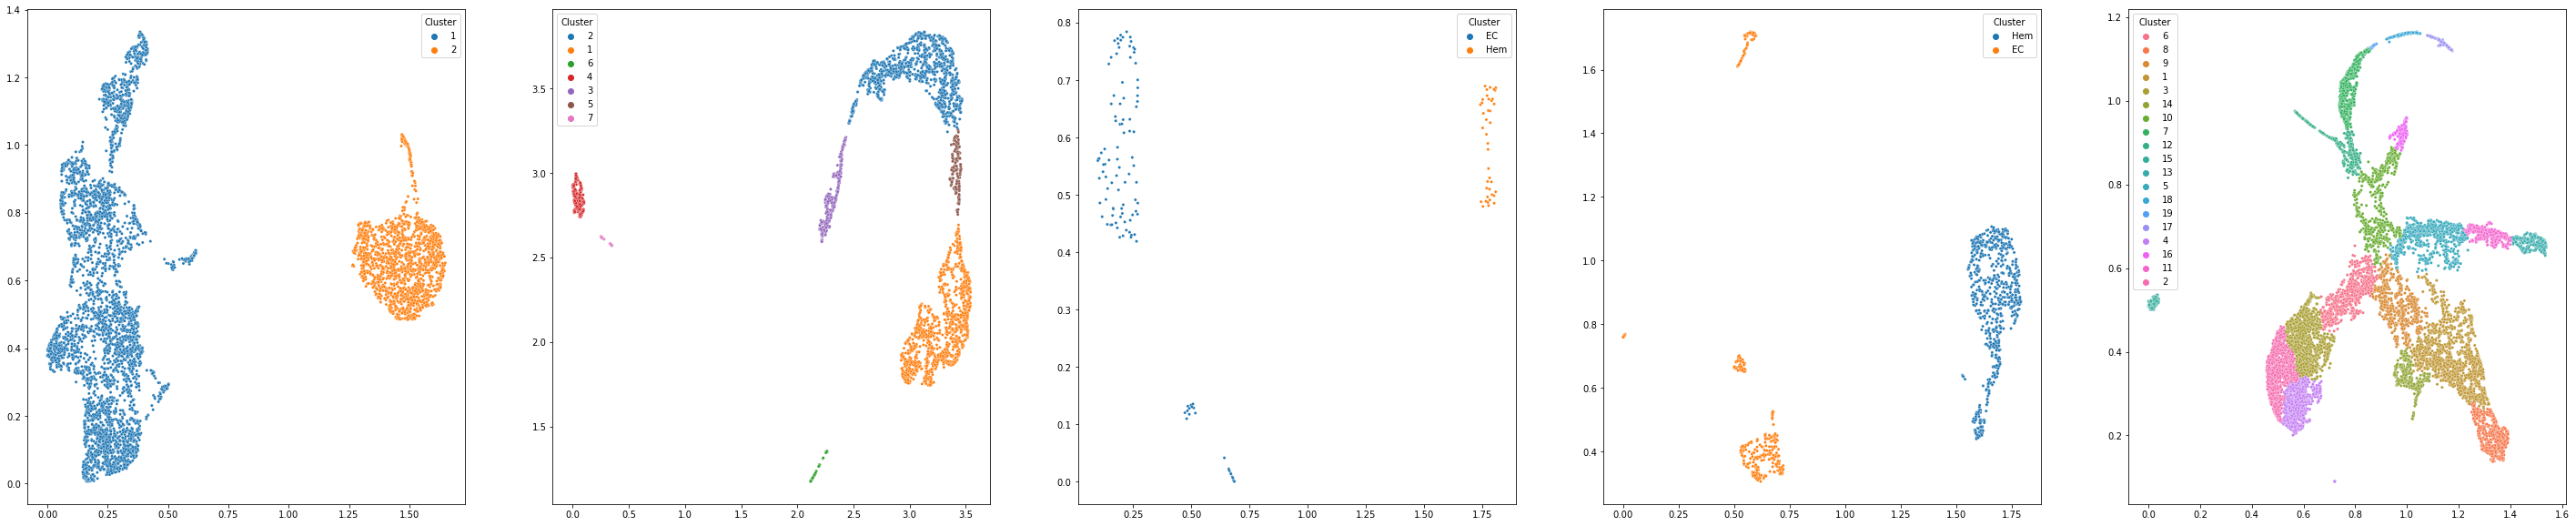

In [3]:
fig,ax = plt.subplots(1,len(l),figsize=[50,10])

adata_embryo_list = []
for i,file in enumerate(l):
    adata_embryo = scp.read("../Data_other_studies/Hadland/Metadata/"+file+".h5ad")
    adata_embryo.var["gene_id"] = adata_embryo.var["id"].values
    adata_embryo.var.set_index("id",inplace=True)
    
    scp.pp.highly_variable_genes(adata_embryo,flavor="seurat_v3",n_top_genes=2000)
    scp.pp.normalize_total(adata_embryo,target_sum=adata_embryo.X.sum(axis=1).mean())

    adata_embryo_list.append(adata_embryo.copy())
    
    sns.scatterplot(adata_embryo.obsm["UMAP"][:,0],adata_embryo.obsm["UMAP"][:,1],adata_embryo.obs["Cluster"].astype(str),s=10,ax=ax[i])

In [4]:
adata_gastruloid = scp.read(DIRECTORY+"Results/QC.h5ad")
adata_gastruloid.var["gene_id"] = adata_gastruloid.var.index.values

# Centroid

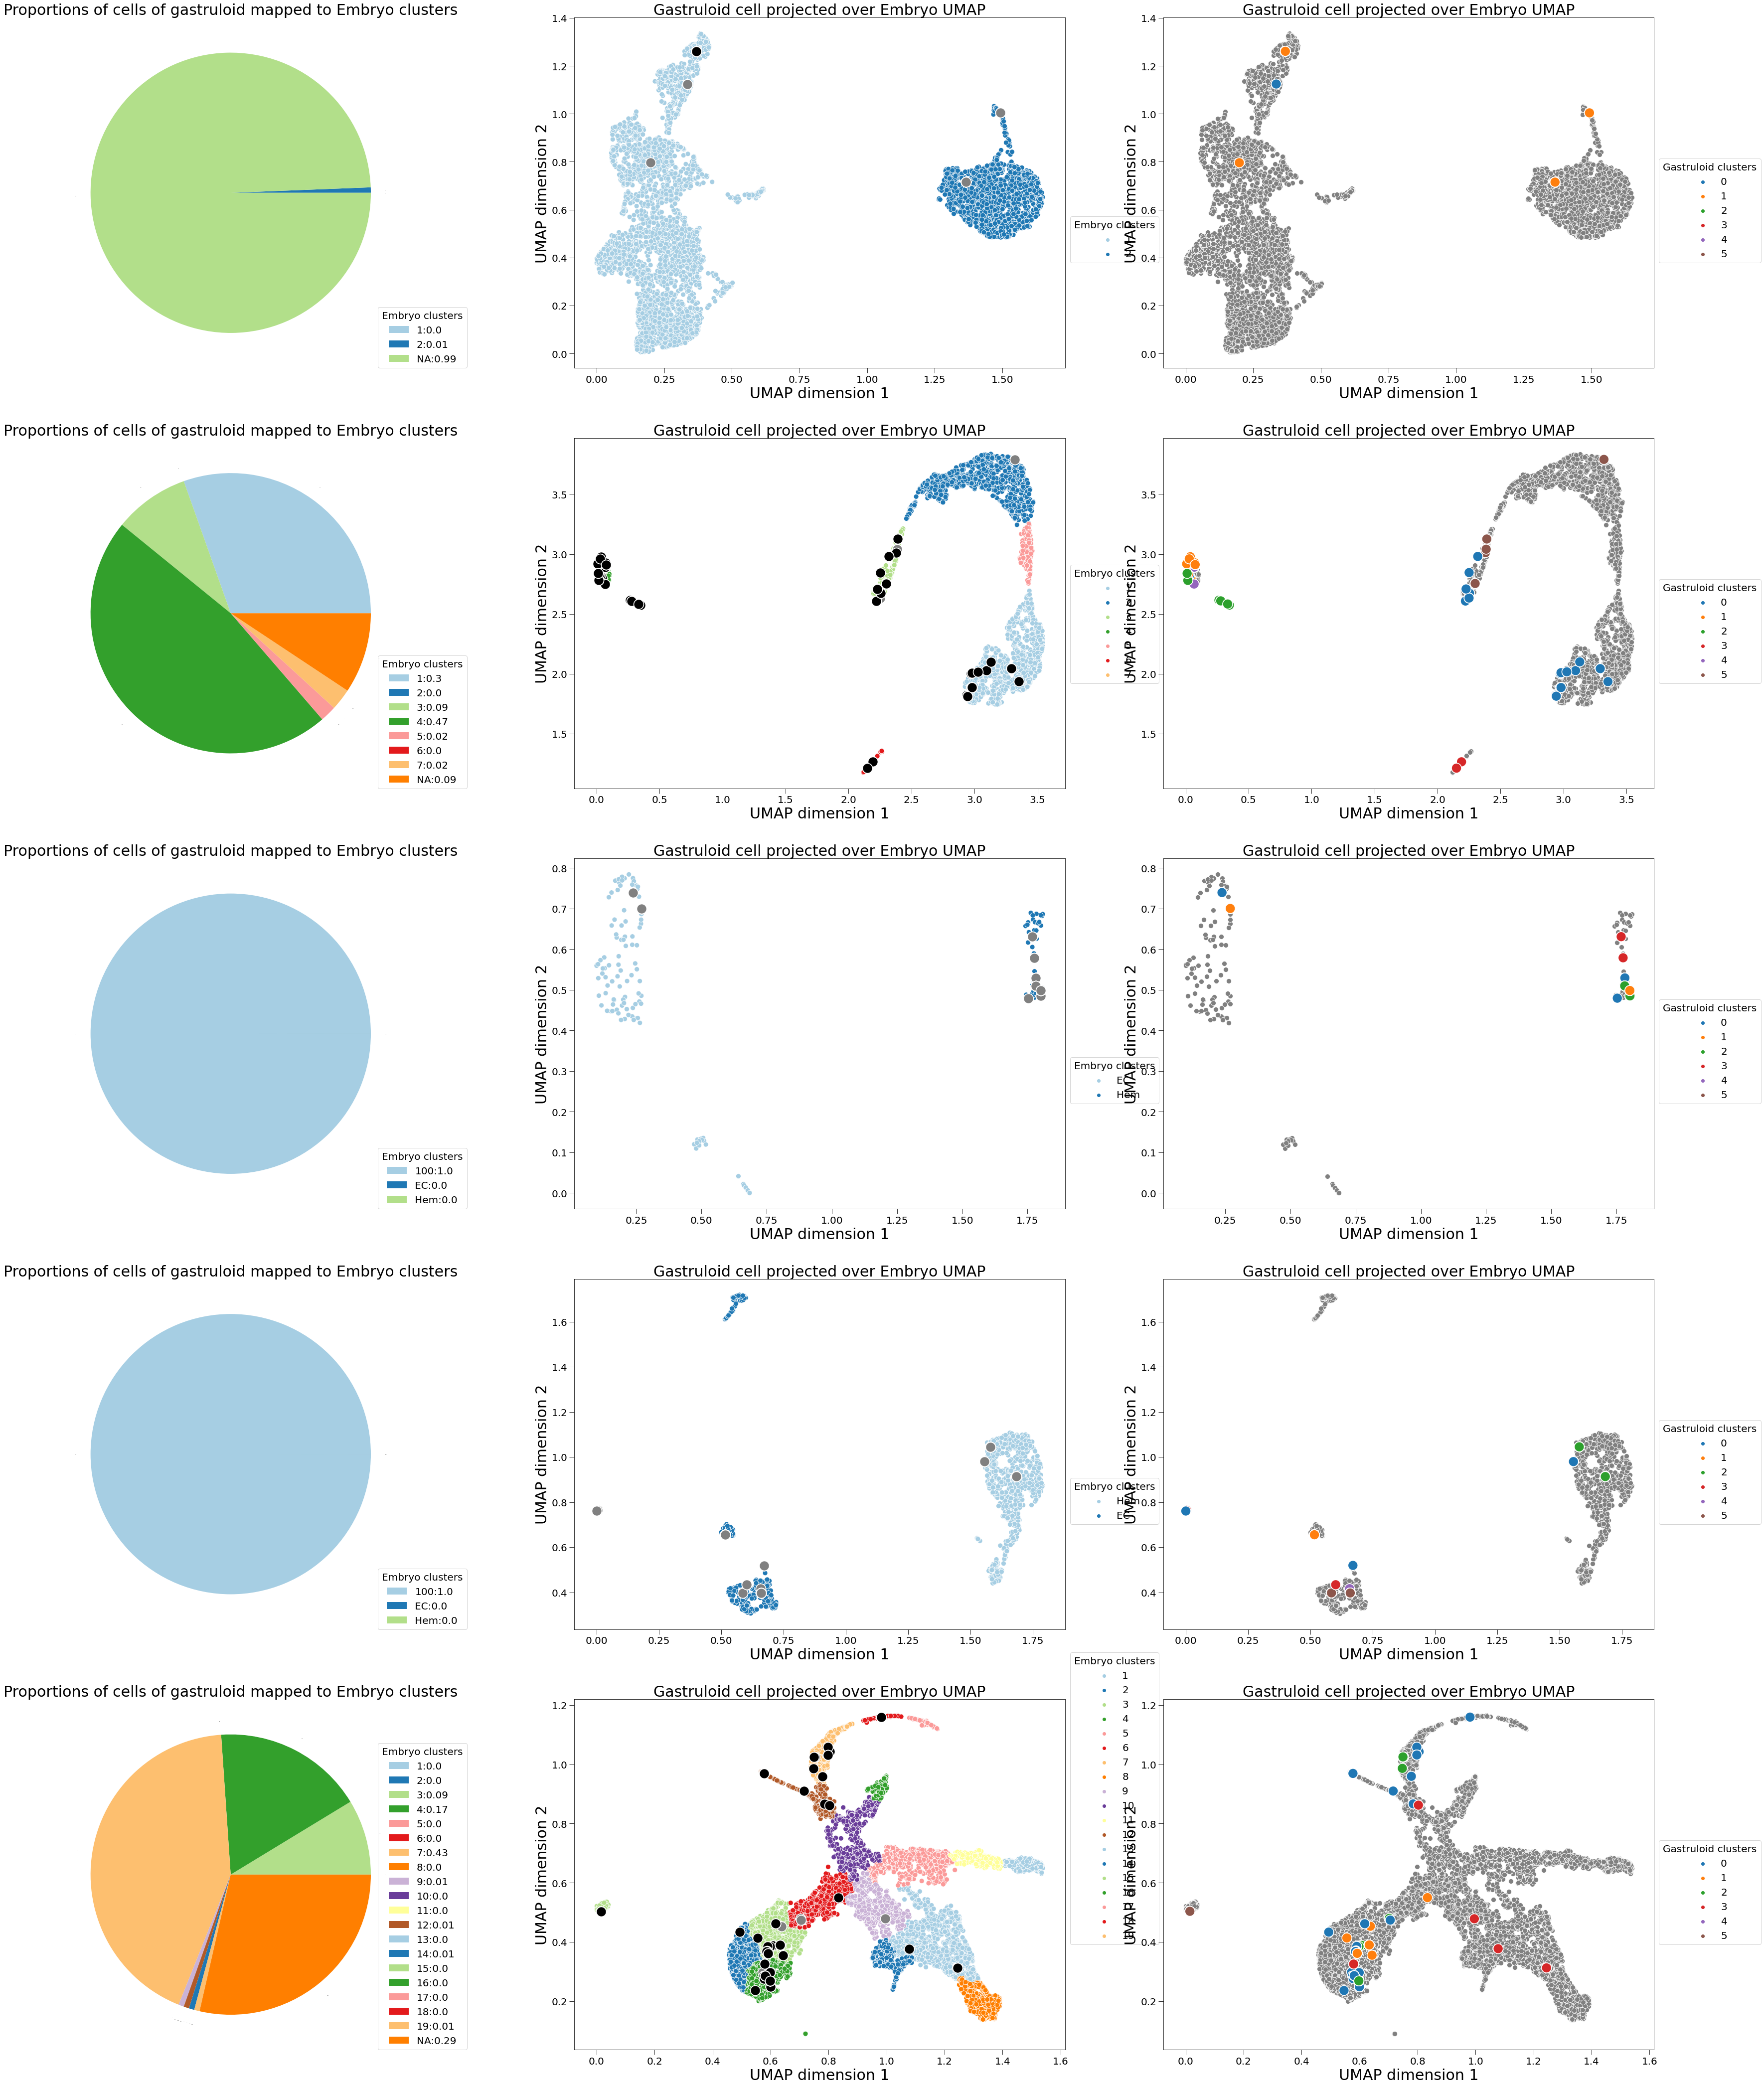

In [5]:
fig,ax = plt.subplots(5,3,figsize=[60,75])
noise_factor = 0.03

for i in range(5):
    scttools.scmap_annotate(adata_gastruloid,adata_embryo_list[i],"gene_id","Cluster",key_added="Annotation",similarity_threshold=.7,algorithm_flavor="centroid",unassigned_label="100",verbose=False)
    scttools.scmap_projection(adata_gastruloid,adata_embryo_list[i],"gene_id","UMAP",key_added="Annotation",verbose=False)

    m = adata_gastruloid.obs.groupby("Annotation").count()
    for j in adata_embryo_list[i].obs.groupby("Cluster",dropna=False).count().index:
        if str(j) not in m.index.values:
            m.loc[str(j),:] = .001
    try:
        m.index = m.index.astype(int)
        m.sort_index(inplace=True)
        labels = [str(k)+":"+str(np.round(j,decimals=2)) for k,j in zip(m.index,m.iloc[:,0]/m.iloc[:,0].sum())]
        labels[-1] = "NA:"+labels[-1][4:]
    except:
        labels = [str(k)+":"+str(np.round(j,decimals=2)) for k,j in zip(m.index,m.iloc[:,0]/m.iloc[:,0].sum())]   
        
    m.plot.pie(y="Cell",ax=ax[i,0],fontsize=0,labels=labels,colors=sns.color_palette("Paired"))
    sctplot.plot_base(ax[i,0],title="Proportions of cells of gastruloid mapped to Embryo clusters",labels=["",""],legend_pos=(.92,0),legend_title="Embryo clusters")

    try:
        order = np.argsort(adata_embryo_list[i].obs["Cluster"].astype(int)).values    
    except:
        order = range(adata_embryo_list[i].shape[0])
    sns.scatterplot(adata_embryo_list[i].obsm["UMAP"][order,0],adata_embryo_list[i].obsm["UMAP"][order,1]
                    ,hue=adata_embryo_list[i].obs["Cluster"].astype(str).iloc[order],ax=ax[i,1],s=100,palette="Paired")
    only = adata_gastruloid.obs["Annotation"] == "100"
    sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[i,1],color="grey",s=400)
    only = adata_gastruloid.obs["Annotation"] != "100"
    sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[i,1],color="black",s=400)
    sctplot.plot_base(ax[i,1],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(1.01,.3),legend_title="Embryo clusters")

    sns.scatterplot(adata_embryo_list[i].obsm["UMAP"][:,0],adata_embryo_list[i].obsm["UMAP"][:,1],color="grey",ax=ax[i,2],s=100,palette="Paired")
    sns.scatterplot(adata_gastruloid.obsm["Annotation"][:,0],adata_gastruloid.obsm["Annotation"][:,1],hue=adata_gastruloid.obs["leiden"].values,ax=ax[i,2],s=400)
    sctplot.plot_base(ax[i,2],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(1.01,.3),legend_title="Gastruloid clusters")
    
fig.savefig(DIRECTORY+"Plots/Proj_Hadland_centroid_mapping.pdf",bbox_inches="tight",transparent=True)

# Cell

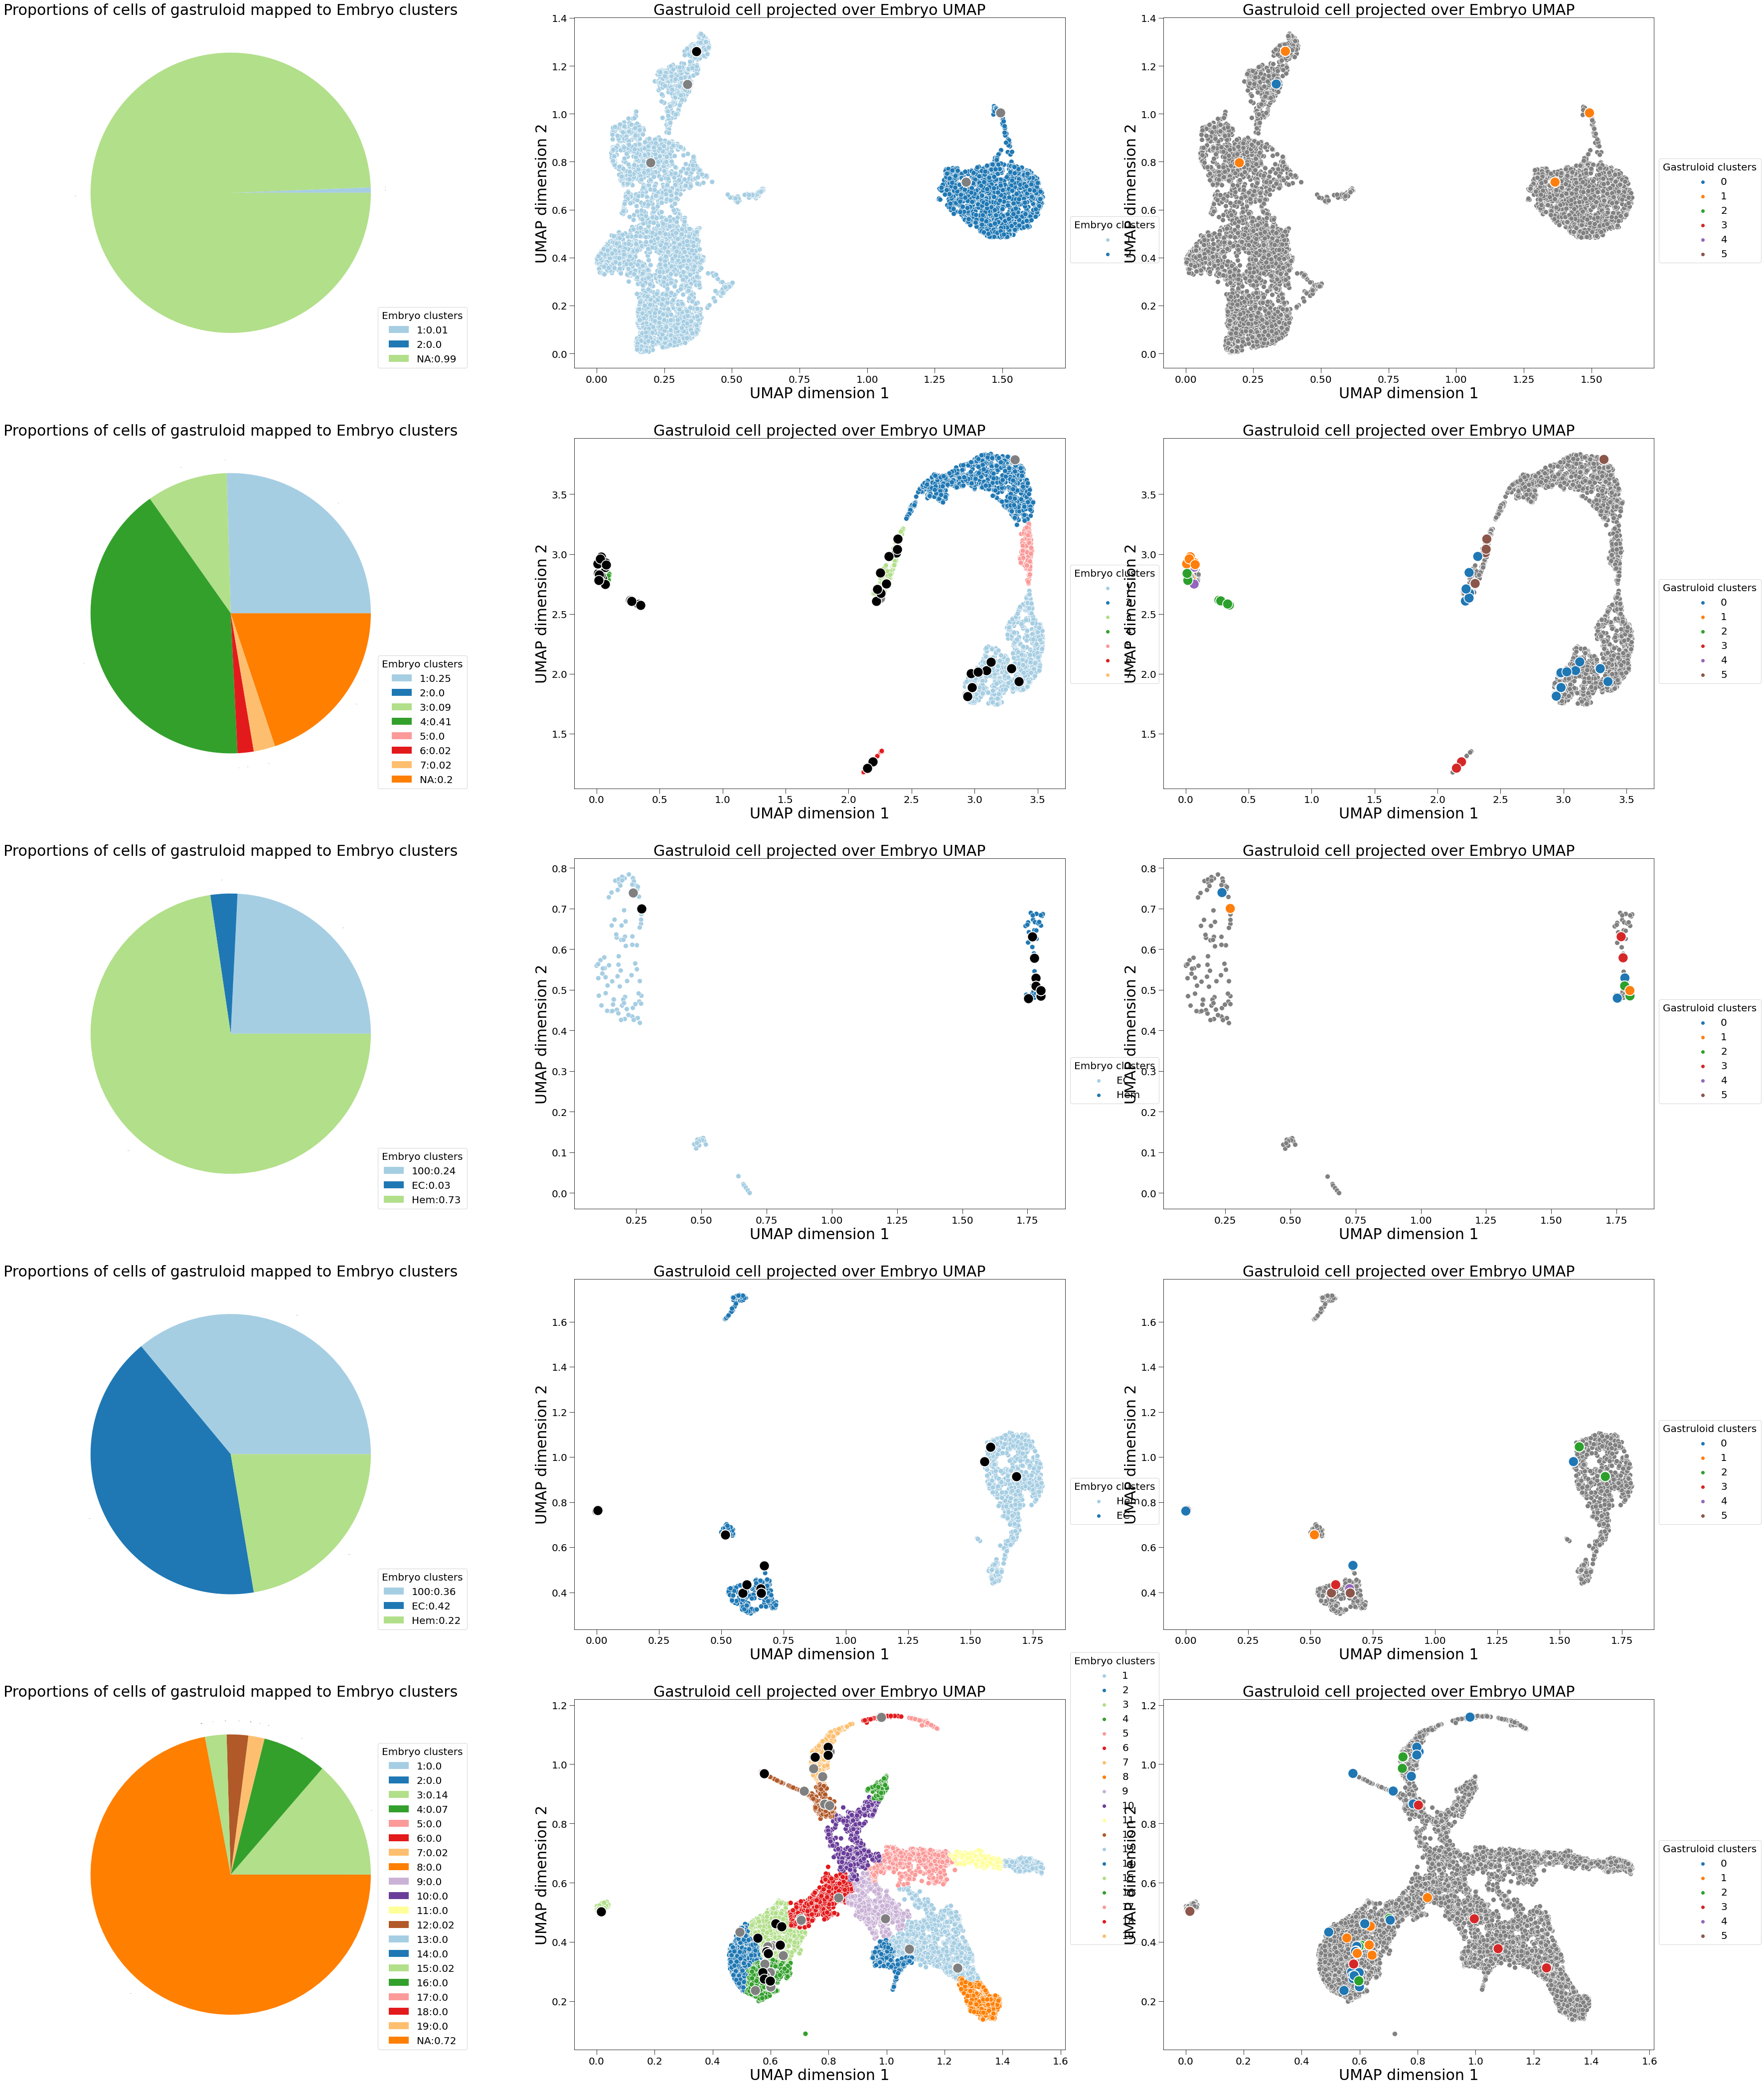

In [6]:
fig,ax = plt.subplots(5,3,figsize=[60,75])
noise_factor = 0.03

for i in range(5):
    scttools.scmap_annotate(adata_gastruloid,adata_embryo_list[i],"gene_id","Cluster",key_added="Annotation",similarity_threshold=.7,algorithm_flavor="cell",unassigned_label="100",verbose=False)
    scttools.scmap_projection(adata_gastruloid,adata_embryo_list[i],"gene_id","UMAP",key_added="Annotation",verbose=False)

    m = adata_gastruloid.obs.groupby("Annotation").count()
    for j in adata_embryo_list[i].obs.groupby("Cluster",dropna=False).count().index:
        if str(j) not in m.index.values:
            m.loc[str(j),:] = .001
    try:
        m.index = m.index.astype(int)
        m.sort_index(inplace=True)
        labels = [str(k)+":"+str(np.round(j,decimals=2)) for k,j in zip(m.index,m.iloc[:,0]/m.iloc[:,0].sum())]
        labels[-1] = "NA:"+labels[-1][4:]
    except:
        labels = [str(k)+":"+str(np.round(j,decimals=2)) for k,j in zip(m.index,m.iloc[:,0]/m.iloc[:,0].sum())]   
        
    m.plot.pie(y="Cell",ax=ax[i,0],fontsize=0,labels=labels,colors=sns.color_palette("Paired"))
    sctplot.plot_base(ax[i,0],title="Proportions of cells of gastruloid mapped to Embryo clusters",labels=["",""],legend_pos=(.92,0),legend_title="Embryo clusters")

    try:
        order = np.argsort(adata_embryo_list[i].obs["Cluster"].astype(int)).values    
    except:
        order = range(adata_embryo_list[i].shape[0])
    sns.scatterplot(adata_embryo_list[i].obsm["UMAP"][order,0],adata_embryo_list[i].obsm["UMAP"][order,1]
                    ,hue=adata_embryo_list[i].obs["Cluster"].astype(str).iloc[order],ax=ax[i,1],s=100,palette="Paired")
    only = adata_gastruloid.obs["Annotation"] == "100"
    sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[i,1],color="grey",s=400)
    only = adata_gastruloid.obs["Annotation"] != "100"
    sns.scatterplot(adata_gastruloid.obsm["Annotation"][only,0],adata_gastruloid.obsm["Annotation"][only,1],ax=ax[i,1],color="black",s=400)
    sctplot.plot_base(ax[i,1],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(1.01,.3),legend_title="Embryo clusters")

    sns.scatterplot(adata_embryo_list[i].obsm["UMAP"][:,0],adata_embryo_list[i].obsm["UMAP"][:,1],color="grey",ax=ax[i,2],s=100,palette="Paired")
    sns.scatterplot(adata_gastruloid.obsm["Annotation"][:,0],adata_gastruloid.obsm["Annotation"][:,1],hue=adata_gastruloid.obs["leiden"].values,ax=ax[i,2],s=400)
    sctplot.plot_base(ax[i,2],title="Gastruloid cell projected over Embryo UMAP",labels=["UMAP dimension 1","UMAP dimension 2"],legend_pos=(1.01,.3),legend_title="Gastruloid clusters")
    
fig.savefig(DIRECTORY+"Plots/Proj_Hadland_cell_mapping.pdf",bbox_inches="tight",transparent=True)

# DE genes from embryo expressed in gastruloid clusters

... storing 'Cluster' as categorical
... storing 'Annotation' as categorical
... storing 'Cluster' as categorical
... storing 'Cluster' as categorical
... storing 'Cluster' as categorical
... storing 'Cluster' as categorical


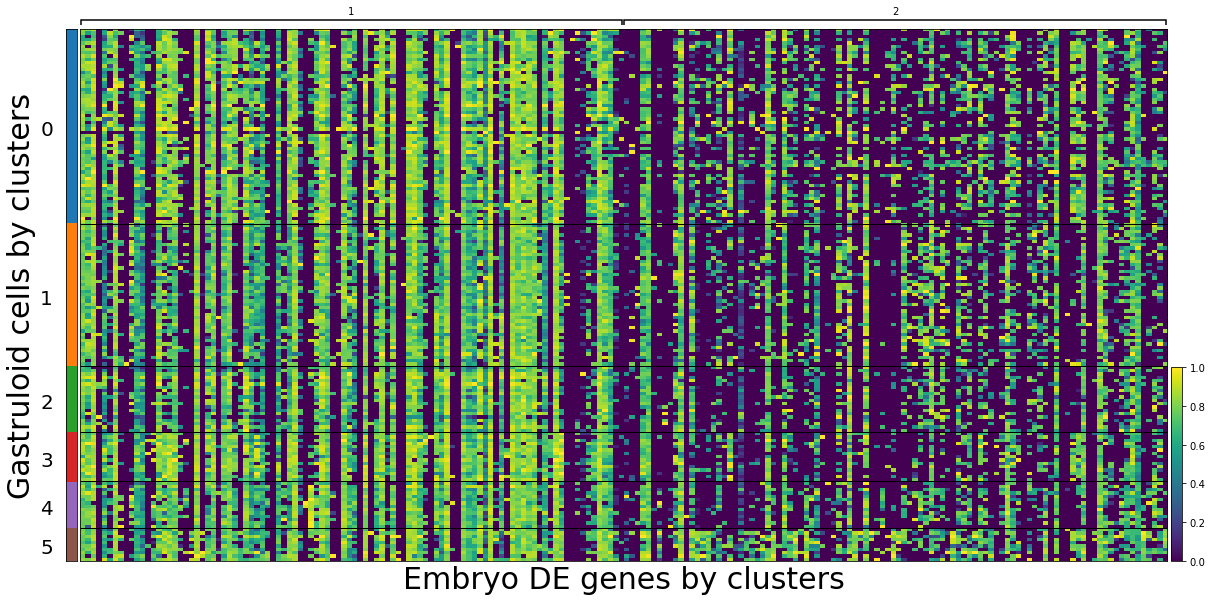

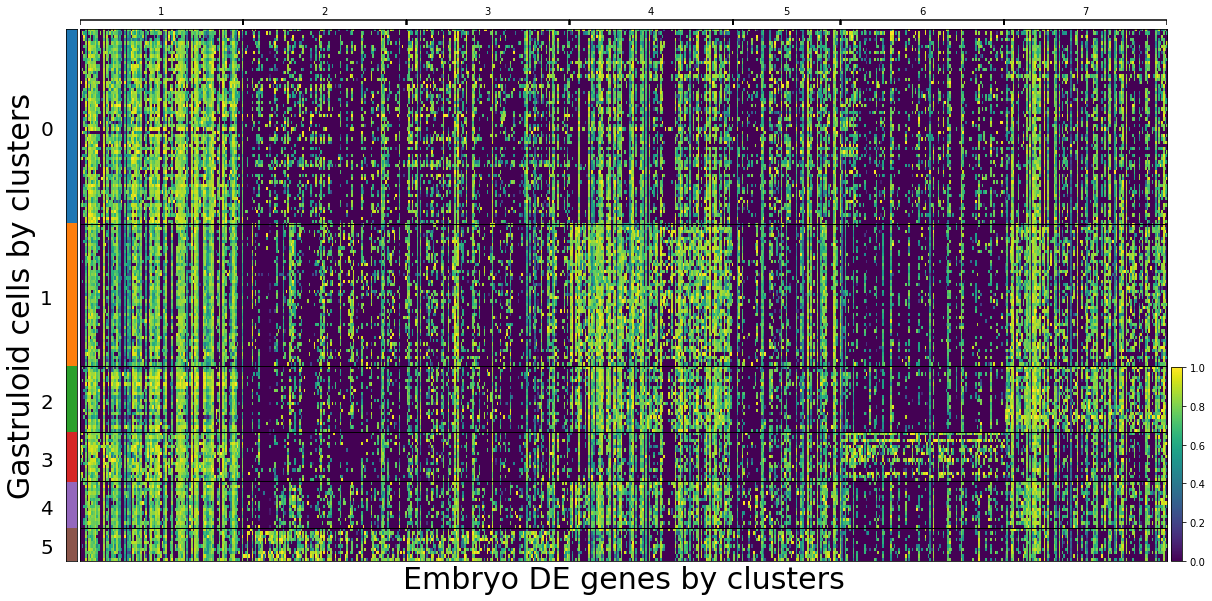

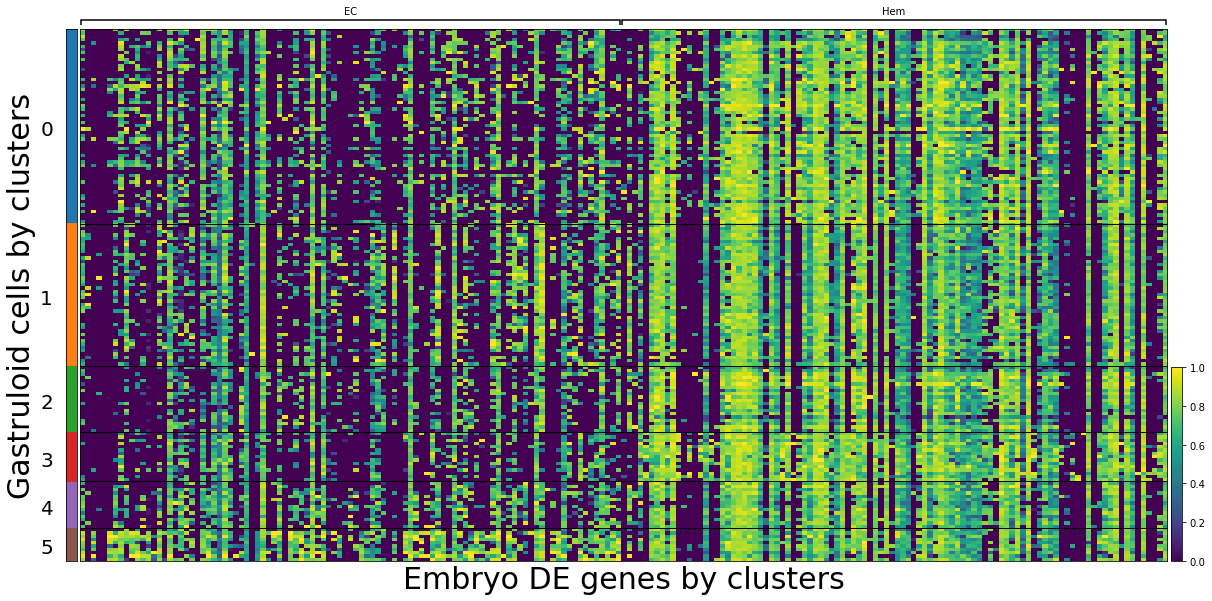

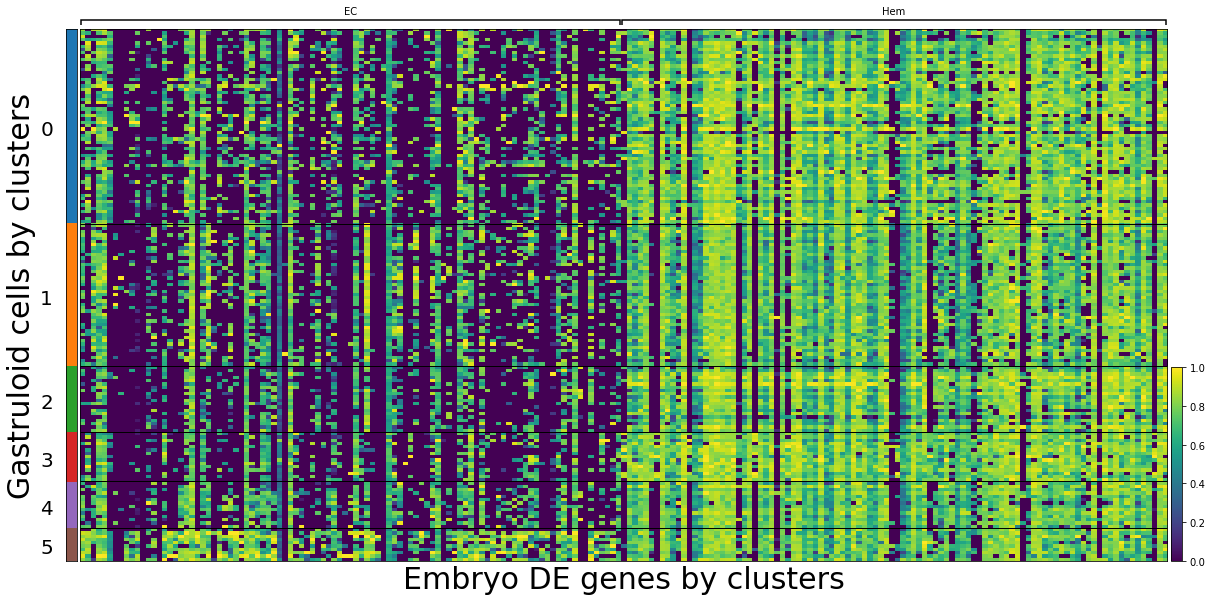

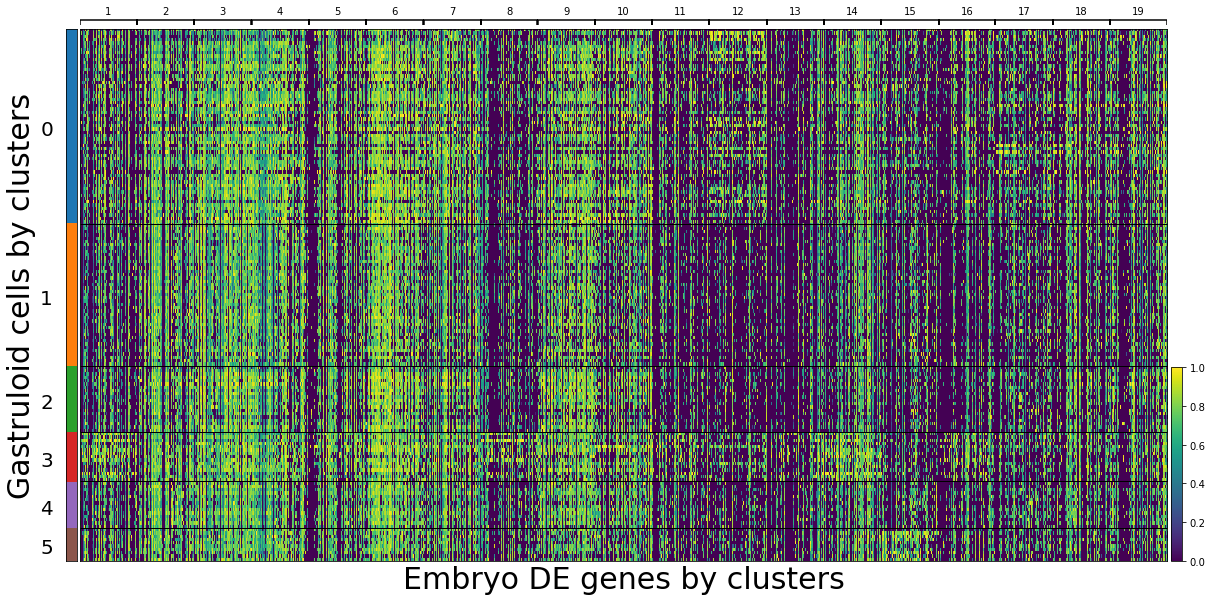

In [7]:
for k in range(5):
    adata_embryo_list[k].obs["Cluster"] = adata_embryo_list[k].obs["Cluster"].astype(str)
    adata_embryo_list[0].var
    scp.tl.rank_genes_groups(adata_embryo_list[k],groupby="Cluster",method="wilcoxon")

    cut = 5

    cluster_genes = {}
    for i,group in enumerate(adata_embryo_list[k].obs["Cluster"].cat.categories.values):
        cluster_genes[group] = []
        for j in range(100):
            if adata_embryo_list[k].uns["rank_genes_groups"]["scores"][j][i] > cut and adata_embryo_list[k].uns["rank_genes_groups"]["names"][j][i] in adata_gastruloid.var["gene_id"].values:
                cluster_genes[group].append(adata_embryo_list[k].uns["rank_genes_groups"]["names"][j][i])

    fig = scp.pl.heatmap(adata_gastruloid, cluster_genes, groupby="leiden", standard_scale="var", swap_axes=False, figsize=(20,10),show=False)
    sctplot.plot_base(fig["heatmap_ax"],title="",labels=["Embryo DE genes by clusters",""],legend=False)
    sctplot.plot_base(fig["groupby_ax"],title="",labels=["","Gastruloid cells by clusters"],legend=False)

    plt.savefig(DIRECTORY+"Plots/Proj_Hadland"+l[k]+"_DE_projected.pdf",bbox_inches="tight",transparent=True)